# EDA: Google, Amazon, Apple and Microsoft Employee Reviews

In this notebook, I will do some exploratory data analysis on [employee reviews](https://www.kaggle.com/petersunga/google-amazon-facebook-employee-reviews) data for some of the top tech companies in US and see if we can uncover any interesting trends.

The idea is to first start with some simple summary statistics, then move to visualizing some of the data in order to get better context. At end, we will explore the reviews themselves to figure out what people are saying about each company.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import nltk
#nltk.download("stopwords") 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download("wordnet")
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud

## 1. Getting the data

In [2]:
df = pd.read_csv('Data/employee_reviews.csv')
df.head()

,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
0,1,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,none,5.0,4.0,5.0,5.0,4.0,5.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
1,2,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,4.0,2.0,3.0,3.0,5.0,3.0,2094,https://www.glassdoor.com/Reviews/Google-Revie...
2,3,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,5.0,4.0,5.0,5.0,4.0,949,https://www.glassdoor.com/Reviews/Google-Revie...
3,4,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5.0,2.0,5.0,5.0,4.0,5.0,498,https://www.glassdoor.com/Reviews/Google-Revie...
4,5,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5.0,5.0,5.0,5.0,5.0,5.0,49,https://www.glassdoor.com/Reviews/Google-Revie...


## 2. Cleaning and Transforming the data

In [3]:
df.shape

(67529, 17)

In [4]:
# Percentage of data points per company
df["company"].value_counts()/len(df["company"])*100

amazon       39.138740
microsoft    26.551556
apple        19.176946
google       11.578729
facebook      2.354544
netflix       1.199485
Name: company, dtype: float64

In [5]:
df = df.drop(['link', 'advice-to-mgmt'], axis=1)
df = df.loc[~df['company'].isin(['facebook', 'netflix']), :]
df = df.loc[df['dates'] != 'None', :]
df['year'] = pd.to_datetime(df['dates'], errors='coerce').dt.year
df.dropna(how='all', inplace=True)
df.dropna(subset=['company', 'year', "overall-ratings", "job-title"], inplace=True)
df['year'] = df['year'].astype('int64')
df.head()

,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,year
0,1,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,5.0,4.0,5.0,5.0,4.0,5.0,0,2018
1,2,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,4.0,2.0,3.0,3.0,5.0,3.0,2094,2013
2,3,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",5.0,5.0,4.0,5.0,5.0,4.0,949,2014
3,4,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,5.0,2.0,5.0,5.0,4.0,5.0,498,2015
4,5,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",5.0,5.0,5.0,5.0,5.0,5.0,49,2018


## 3. Exploratory Data Analysis (EDA)

In [6]:
df.groupby('company')['overall-ratings'].describe()

,count,mean,std,min,25%,50%,75%,max
company,,,,,,,,
amazon,26428.0,3.587294,1.257326,1.0,3.0,4.0,5.0,5.0
apple,12949.0,3.958221,1.064073,1.0,3.0,4.0,5.0,5.0
google,7819.0,4.339430,0.920695,1.0,4.0,5.0,5.0,5.0
microsoft,17930.0,3.816564,1.036499,1.0,3.0,4.0,5.0,5.0


### A. Distribution of Reviews by Company

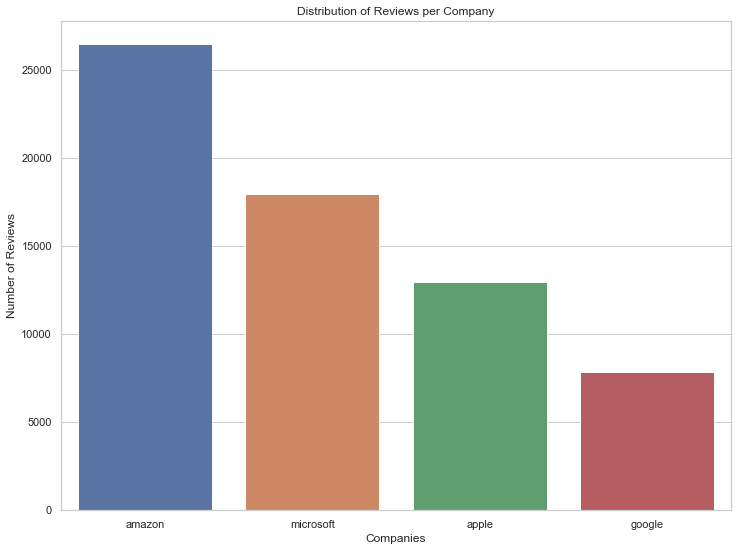

In [7]:
reviews_count = df['company'].value_counts()
comp_labels = reviews_count.index.tolist()
comp_index = np.arange(len(comp_labels))
sns.set(style="whitegrid")

plt.figure(figsize=(12, 9))
sns.barplot(comp_index, reviews_count)
plt.xticks(comp_index, comp_labels)
plt.xlabel('Companies')
plt.ylabel('Number of Reviews')
_ = plt.title('Distribution of Reviews per Company')

**Observations:** We can clearly see that Amazon has the most reviews (25,000+) and Google has the least amount (less than 10,000). 

### C. Reviews per Year

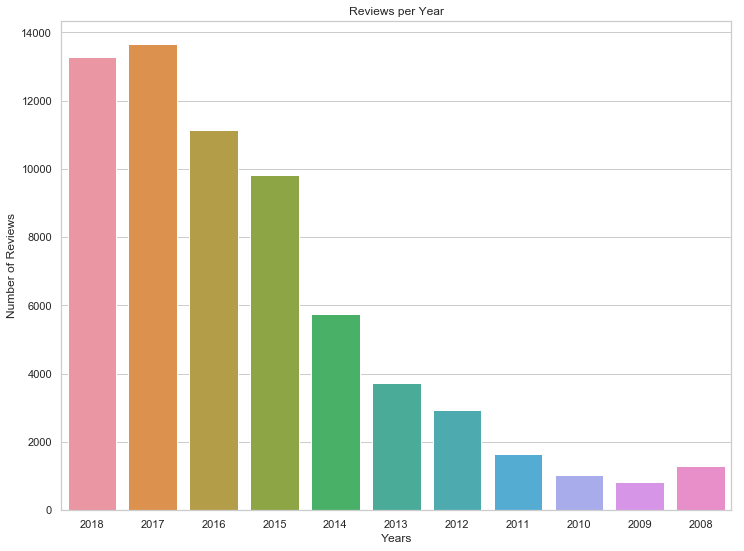

In [8]:
years_count = df['year'].value_counts().sort_index(ascending=False)
years_labels = years_count.index.tolist()
years_index = np.arange(len(years_labels))

plt.figure(figsize=(12, 9))
_ = sns.barplot(years_index, years_count)
_ = plt.xticks(years_index, years_labels)
_ = plt.xlabel("Years")
_ = plt.ylabel("Number of Reviews")
_ = plt.title("Reviews per Year")

**Observations:** We can clearly see that most of the reviews come from the past 3-4 years. But this tell us if all the companies had the most reviews in the past couple of years. 

### D. Reviews per year per company

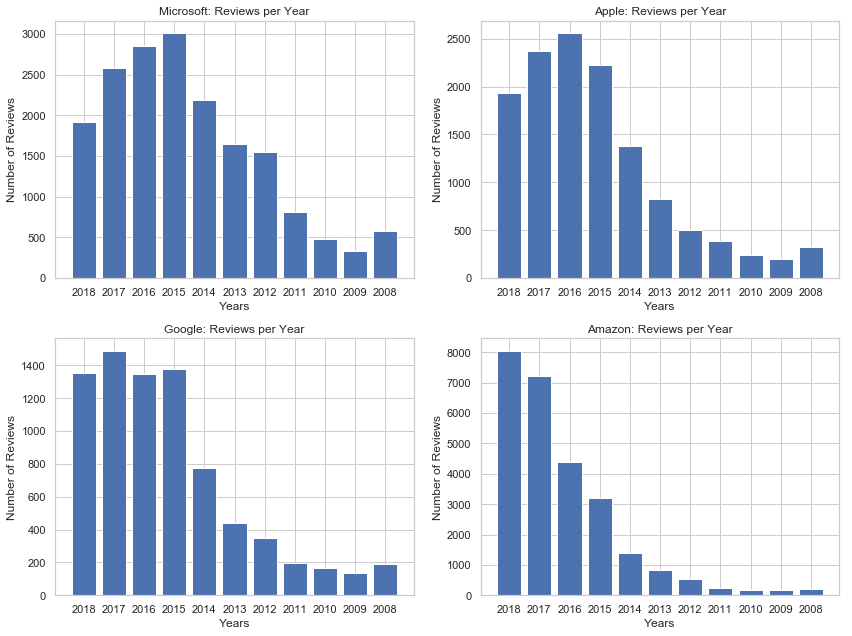

In [9]:
fig, axs = plt.subplots(2,2, figsize=(12, 9), facecolor='w', edgecolor='k')
companies = ['microsoft', 'apple', 'google', 'amazon']
axs = axs.ravel()

for i, company in enumerate(companies):
    
    years_count = df[df['company'] == company]['year'].value_counts().sort_index(ascending=False)
    years_labels = years_count.index.tolist()
    years_index = np.arange(len(years_labels))

    _ = axs[i].bar(years_index, years_count, tick_label = years_labels)
    _ = axs[i].set_xlabel("Years")
    _ = axs[i].set_ylabel("Number of Reviews")
    _ = axs[i].set_title("{}: Reviews per Year".format(company.title()))
    
fig.tight_layout()

**Observations:** Most of the reviews are from the past 3 years (not including 2019). There are reviews from as far back as 2008

* Google: Most reviews from past 4 years
* Apple: Most reviews from past 4-5 years
* Microsoft: Most reviews from past 4-6 years
* Amazon: Most reviews from past 2-4 years


Based on the observations above, ee will only consider reviews from the past 4 years (2015-2018) since they might be the most relevant in figuring out what makes each company good or bad

In [10]:
df = df[df["year"].isin(["2018", "2017", "2016", "2015"])]
df["year"].unique()

array([2018, 2015, 2017, 2016])

### E. Rating over time
How has the average rating of each company changed over the past two years

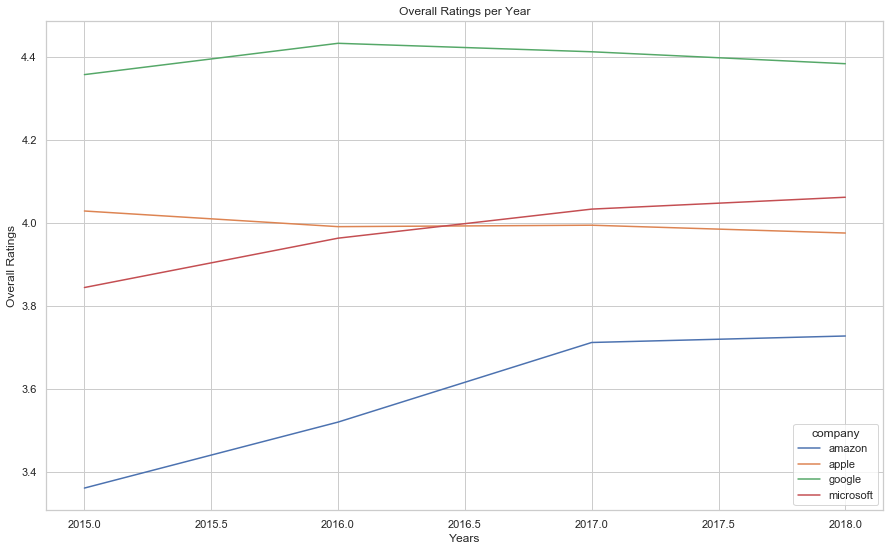

In [11]:
fig, ax = plt.subplots(figsize=(15,9))
df.groupby(['year', 'company'])['overall-ratings'].mean().unstack().plot(ax=ax)
_ = plt.xlabel("Years")
_ = plt.ylabel("Overall Ratings")
_ = plt.title("Overall Ratings per Year")

**Observations:** We can see that the average overall rating for each company has not decreased since 2015, expect for Apple. Google has the highest average overall rating

* Google: Has increased but seems to be have decresed sligtly in the past two years
* Amazon: Has increased dramatically since 2015. Doesn't seem to be decreasing.
* Microsoft: Increasing slowly
* Apple: Seems to be going down.

### B. Distribution of Reviews by type of employee (Current vs Former)

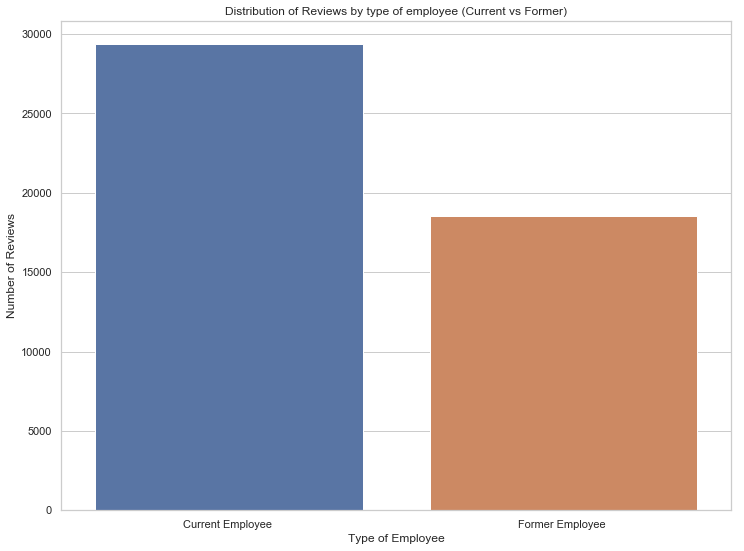

In [12]:
current_employee_count = df['job-title'].str.split('-', expand=True)[0].value_counts()
employee_labels = current_employee_count.index.tolist()
employee_index = np.arange(len(employee_labels))


plt.figure(figsize=(12, 9))
_ = sns.barplot(employee_index, current_employee_count)
_ = plt.xticks(employee_index, employee_labels)

_ = plt.xlabel('Type of Employee')
_ = plt.ylabel('Number of Reviews')
_ = plt.title('Distribution of Reviews by type of employee (Current vs Former)')

**Obeservations:** Most of the reviews seem to come from current employees. Although this is good since it probably means that the reviews are relevant, it also begs the question of how much bias there is.

### Average ratings for different feature (by company)

In [13]:
df.columns

Index(['Unnamed: 0', 'company', 'location', 'dates', 'job-title', 'summary',
       'pros', 'cons', 'overall-ratings', 'work-balance-stars',
       'culture-values-stars', 'carrer-opportunities-stars',
       'comp-benefit-stars', 'senior-mangemnet-stars', 'helpful-count',
       'year'],
      dtype='object')

In [14]:
ratings_comp = df[["company", "work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]]
ratings_comp.set_index(["company"], inplace=True)
ratings_comp = ratings_comp[~(ratings_comp[["work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]] == "none").any(axis=1)]
ratings_comp[["work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]] = ratings_comp[["work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]].apply(pd.to_numeric)
group = ratings_comp.groupby("company")["work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"].mean()
group.columns = ["Work Balance", "Culture Values", "Career Opportunities", "Company Benefits", "Senior Management"]
group = group.transpose()
group

company,amazon,apple,google,microsoft
Work Balance,3.061221,3.354623,4.026761,3.647832
Culture Values,3.558759,4.105820,4.352470,3.781622
Career Opportunities,3.644601,3.462711,4.081885,3.754100
Company Benefits,3.730545,4.113001,4.449680,4.055493
Senior Management,3.196000,3.467120,3.887694,3.348686


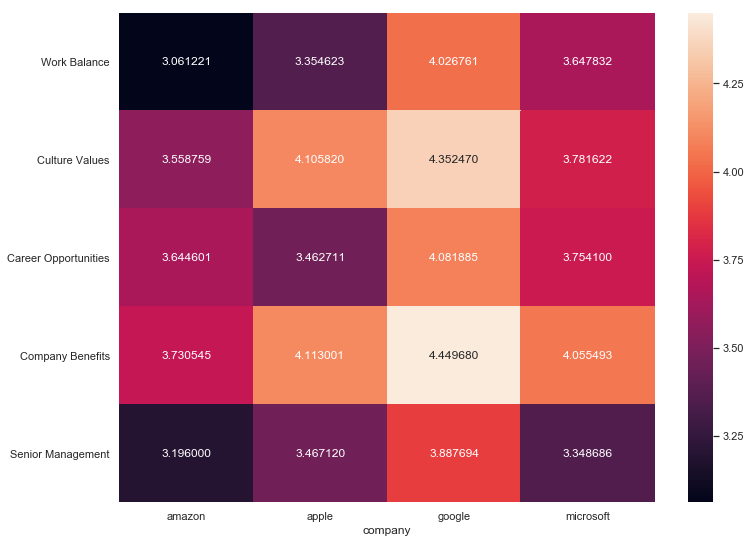

In [15]:
plt.figure(figsize=(12, 9))
_ = sns.heatmap(group, annot=True, fmt="f")

**Observations:** Overall, Google holds the best ratings for Work Balance, Culture Values, Career Opportunities, Company Benefits, and Senior Management. 

* Apple is second in Senior Management, Company Benefits, and Culture Values. 
* Microsoft is second in Work Balance and Career Opportunities.

In [16]:
def rating_per_company(rating_type, title):
    work_ratings = df[['company', rating_type]]
    work_ratings = work_ratings[~(work_ratings[[rating_type]] == "none").any(axis=1)]
    work_ratings[rating_type] = work_ratings[rating_type].apply(pd.to_numeric)
    group = work_ratings.groupby(work_ratings["company"].str.title())[rating_type].mean().reset_index()
    group.sort_values([rating_type],inplace=True)
    group.set_index('company').plot.barh(legend=False, figsize=(12, 10))
    plt.title('{} Rating'.format(title))
    plt.xlabel('Rating')
    _ = plt.ylabel('Company')

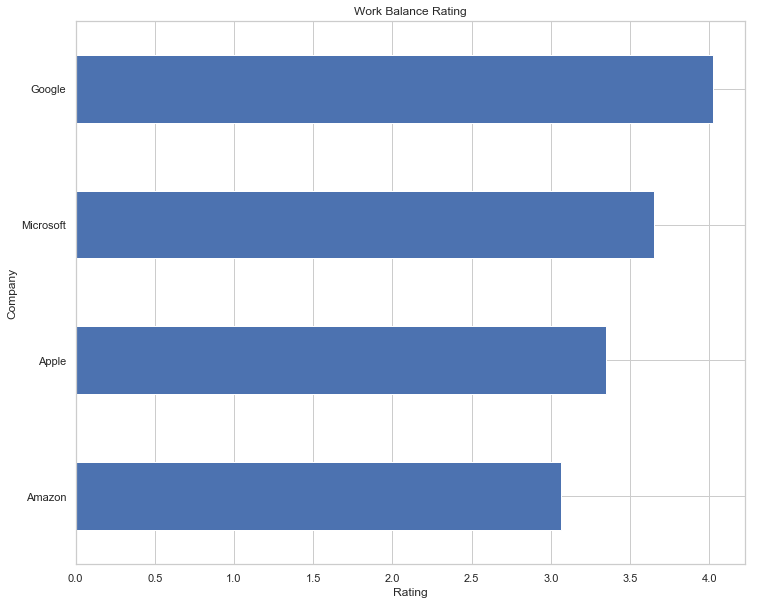

In [17]:
rating_per_company('work-balance-stars', "Work Balance")

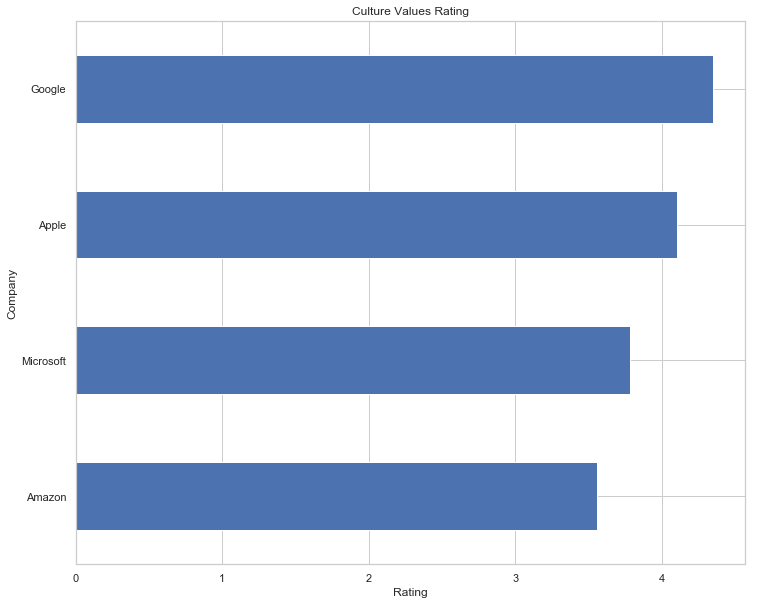

In [18]:
rating_per_company("culture-values-stars", "Culture Values")

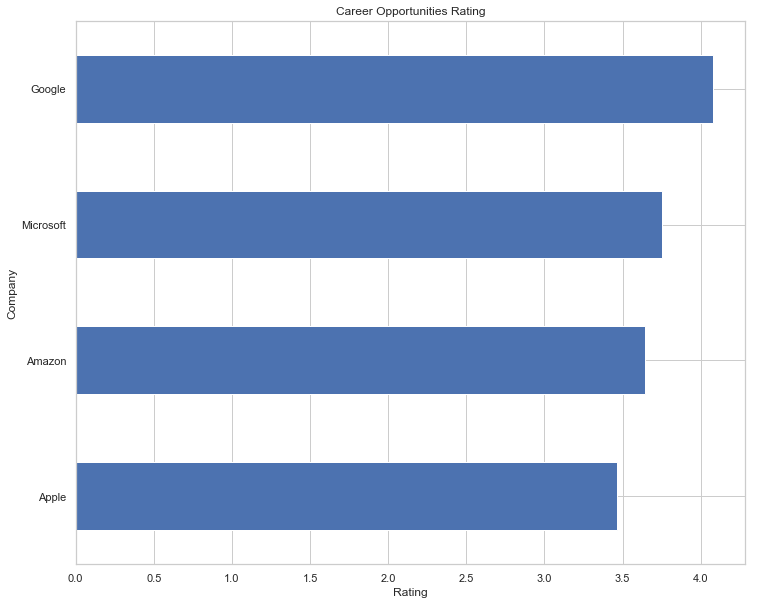

In [19]:
rating_per_company("carrer-opportunities-stars", "Career Opportunities")

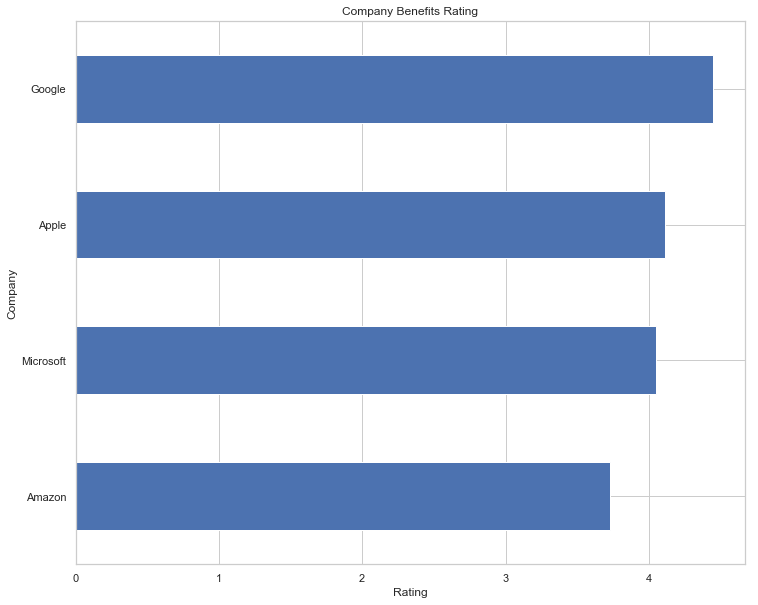

In [20]:
rating_per_company("comp-benefit-stars", "Company Benefits")

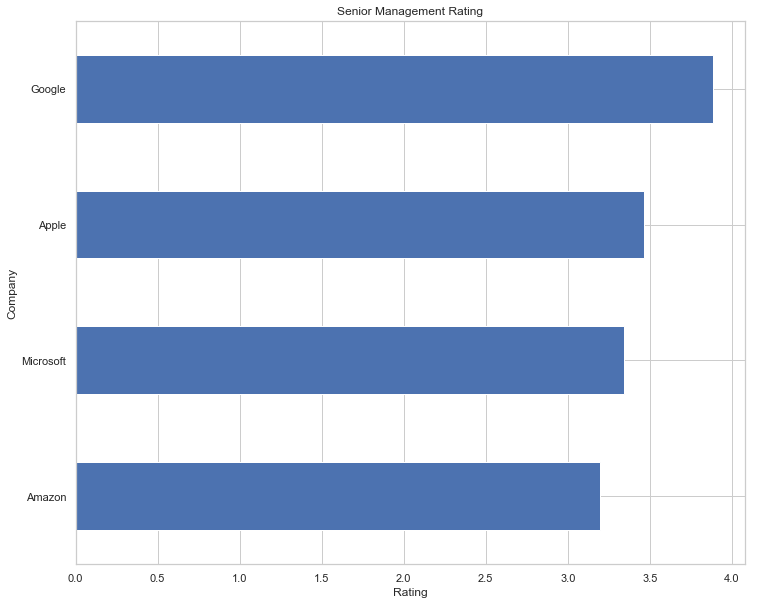

In [21]:
rating_per_company("senior-mangemnet-stars", "Senior Management")

### F. Who is reviewing
Identify, who is reviewing, current or former employee, what title?

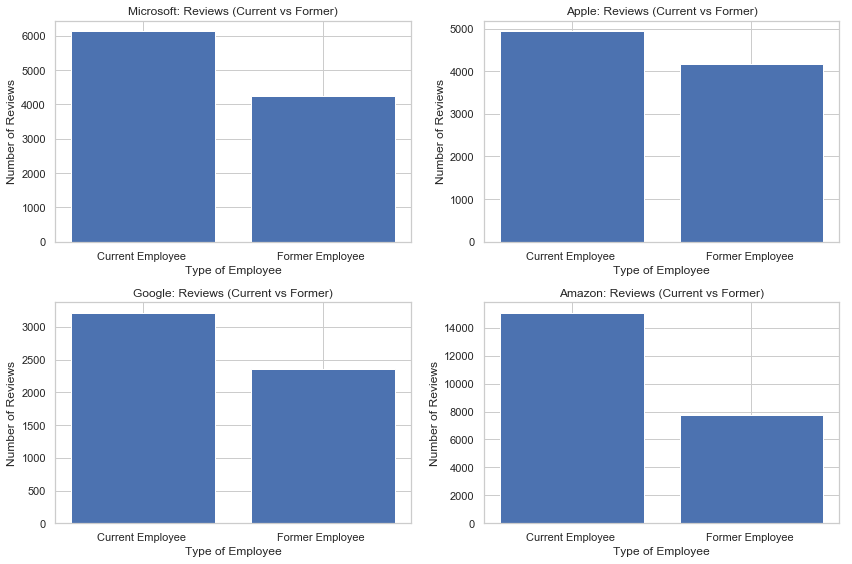

In [26]:
fig, axs = plt.subplots(2,2, figsize=(12, 8), facecolor='w', edgecolor='k')
companies = ['microsoft', 'apple', 'google', 'amazon']
axs = axs.ravel()


for i, company in enumerate(companies):
    current_employee_count = df.loc[df['company'] == company]['job-title'].str.split('-', expand=True)[0].value_counts()
    employee_labels = current_employee_count.index.tolist()
    employee_index = np.arange(len(employee_labels))
        
    _ = axs[i].bar(employee_index, current_employee_count, tick_label=employee_labels)

    _ = axs[i].set_xlabel('Type of Employee')
    _ = axs[i].set_ylabel('Number of Reviews')
    _ = axs[i].set_title('{}: Reviews (Current vs Former)'.format(company.title()))
    
fig.tight_layout()

**Obersevations:** We can clearly see that most of the reviews for each company come from current employees.

In [27]:
df['job-title'].str.split(' - ', expand=True)[1].value_counts().head(5)

Anonymous Employee               21910
Software Engineer                  930
Specialist                         648
Software Development Engineer      618
Warehouse Associate                585
Name: 1, dtype: int64

**Obeservations:** Most of the job titles is anonymous. Based on this, it many not be worth it to summarize the data based on the job title.

### G. Average Rating of Current vs Former Employee (per Company)

Let's see what the average rating of current and former employees per company

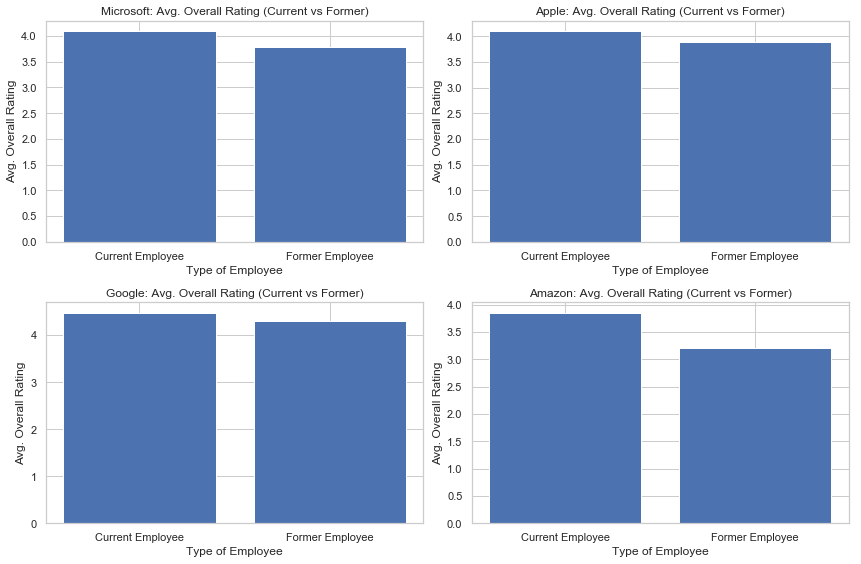

In [33]:
fig, axs = plt.subplots(2,2, figsize=(12, 8), facecolor='w', edgecolor='k')
companies = ['microsoft', 'apple', 'google', 'amazon']
axs = axs.ravel()


for i, company in enumerate(companies):
    
    job_rating = df[df['company'] == company][['job-title', 'overall-ratings']]
    job_rating['job-title'] = job_rating['job-title'].str.split(' - ', expand=True)[0]
    job_rating_count = job_rating.groupby('job-title')['overall-ratings'].mean()
    
    _ = axs[i].bar([0,1], job_rating_count, tick_label = ['Current Employee', 'Former Employee'])
    _ = axs[i].set_title('{}: Avg. Overall Rating (Current vs Former)'.format(company.title()))
    _ = axs[i].set_xlabel("Type of Employee")
    _ = axs[i].set_ylabel("Avg. Overall Rating")

fig.tight_layout()

**Observations:** Based on the plots above, we can see the Amazon has the biggest difference in the overall rating between current and former employees. One possible reason could be that former employees left the company because they had a negative experience.

### What are Pros and Cons about
Identify trend or top keywords in the pros and cons comments

In [34]:
pd.set_option('display.max_colwidth', -1)
df[['pros']].head(5)

pros
0  People are smart and friendly                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [35]:
pros_count = df['pros'].str.split().str.len()
cons_count = df['cons'].str.split().str.len()
#summary_count = df['summary'].str.split().str.len()

In [ ]:
pros_count.describe()

In [ ]:
cons_count.describe()

**Observations:** We can that the word count between comments varies by a lot. We have reviews with just a few words and others that are multiple paragraphs. 50% of comments (pros and cons) are between 12-15 words long.

## Clean and Transform Data

In [ ]:
stop_words = set(stopwords.words("english"))
stop_words = stop_words.union(df["company"].unique()) # Include Company names
print(stop_words)

In [ ]:
def top_words(company, review_type, stop_words, top=20):
    
    corpus = df[df['company'] == company][review_type].str.lower()

    # Remove punctuations
    corpus = corpus.str.replace("[^a-zA-Z]", " ")

    # Convert to list from string
    corpus = corpus.str.split()

    # Remove stop words
    corpus = corpus.apply(lambda x: [word for word in x if word not in stop_words])


    # Lemmatisation
    lem = WordNetLemmatizer()

    def lemmatize_text(text):
        return [lem.lemmatize(word) for word in text]

    corpus = corpus.apply(lemmatize_text)

    corpus = corpus.apply(pd.Series).stack()
    
    return set(corpus.value_counts()[:top].index.tolist())

In [ ]:
google_pros = top_words("google", "pros", stop_words)
micro_pros = top_words("microsoft", "pros", stop_words)
apple_pros = top_words("apple", "pros", stop_words)
amazon_pros = top_words("amazon", "pros", stop_words)

company_common_pros = set.intersection(google_pros, micro_pros, apple_pros, amazon_pros)
company_common_pros

In [ ]:
google_cons = top_words("google", "cons", stop_words)
micro_cons = top_words("microsoft", "cons", stop_words)
apple_cons = top_words("apple", "cons", stop_words)
amazon_cons = top_words("amazon", "cons", stop_words)

company_common_cons = set.intersection(google_cons, micro_cons, apple_cons, amazon_cons)
company_common_cons

In [ ]:
pd.options.display.max_rows = 4000
cons_common = pd.Series(' '.join(df['cons'].str.lower()).split()).value_counts()[:70]
print(cons_common)

In [ ]:
cons_except = {"hours", "hard", "time", "life"}

In [ ]:
cons_stop = set(cons_common.index.tolist())
cons_stop = cons_stop - set(cons_except)
cons_stop = cons_stop.union(company_common_cons)

In [ ]:
pros_common = pd.Series(' '.join(df['pros'].str.lower()).split()).value_counts()[:70]
print(pros_common)

In [ ]:
pros_except = {"culture", "learn", "smart", "opportunities", "environment", "amazing", "team", "flexible", "opportunity"}

In [ ]:
pros_stop = set(pros_common.index.tolist())
pros_stop = pros_stop - set(pros_except)
pros_stop = pros_stop.union(company_common_pros)

In [ ]:
def create_cloud(company, review_type, new_stop):
    # Convert to lowercase
    corpus = df[df['company'] == company][review_type].str.lower()

    # Remove punctuations
    corpus = corpus.str.replace("[^a-zA-Z]", " ")

    # Convert to list from string
    corpus = corpus.str.split()

    # Remove stop words
    new_stop = stop_words.union(new_stop)
    corpus = corpus.apply(lambda x: [word for word in x if word not in new_stop])


    # Lemmatisation
    lem = WordNetLemmatizer()

    def lemmatize_text(text):
        return [lem.lemmatize(word) for word in text]

    corpus = corpus.apply(lemmatize_text)

    corpus = corpus.str.join(" ")

    # Remove Tags
    #text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

    # Remove special characters and digits
    #corpus = corpus.str.replace("(\\d|\\W)+", " ")
    
    return WordCloud(width=3000, height = 2000, max_words = 50, random_state = 42, background_color = "black", stopwords = new_stop).generate(" ".join(corpus))



**Note:** All companies seem to have a few words in common for pros and cons reviews. These words are so frequent that they make other insightful words difficult to get noticed.

In [ ]:
for i, company in enumerate(df["company"].unique()):
    #ax = fig.add_subplot(1,4,i+1)
    word_cloud = create_cloud(company, "cons", cons_stop)
    
    fig = plt.figure()
    plt.imshow(word_cloud)
    plt.title("{} cons".format(company))
    plt.axis('off')
    #fig.savefig("{}.png".format(company), dpi=900)

**Note:** Aside from stop words, the following words were common (and very frequent) among all 4 companies, but were not included in the wordclouds: 'benefit','company', 'culture', 'environment', 'good', 'great', 'lot', 'opportunity', 'people','work', 'working'

These words are all important in trying to figure out what makes these companies good, but I decided to leave them out in order to make room for other frequent keywords that may be more insighful about each company.

**Observations:**

* Google: Team, Hard word, , the project, politics and life balance
* Amazon: Lack of life-balance, the hours, the culture.
* Apple: The life-balance, retail, customers, the pay
* Microsoft: Politics, the work-life balance, team, the hard work, the culture

In [ ]:
for i, company in enumerate(df["company"].unique()):
    #ax = fig.add_subplot(1,4,i+1)
    word_cloud = create_cloud(company, "pros", pros_stop)
    
    fig = plt.figure()
    plt.imshow(word_cloud)
    plt.title("{} pros".format(company))
    plt.axis('off')
    #fig.savefig("{}.png".format(company), dpi=900)

**Observations:**

* Google: Perks, smart people, Free Food, salary. 
* Amazon: Learn, the team
* Apple: Discount, the products, the team, fun, training
* Microsoft: Smart people, product, the salary, technology, the team. 

## Conclusion

Overall: As we could see from the data, the company with the highest overall rating is Google. Then follows Microsoft, Apple and Amazon.

"Work Balance":
"Culture Values":
"Career Opportunities":
"Company Benefits":
"Senior Management": 

What do people like about each one of these companies?

Google

Microsoft

Apple

Amazon

What do people don't like about each one of these companies?

Google

Microsoft

Apple

Amazon